In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil

In [2]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [3]:
imgs = load_images('../../inputs/dd/')

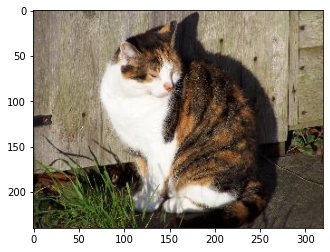

In [4]:
img = cv2.imread('../../inputs/15_19_s.jpg')
# pyplot uses rgb so image is reversed before displaying
plt.imshow(img[:,:,::-1])

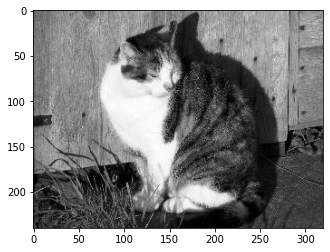

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

## Corner detection

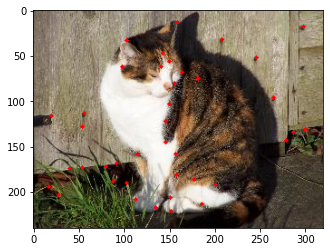

In [6]:
corners = cv2.goodFeaturesToTrack(gray, 40, 0.01, 10)
corners = np.int0(corners)

# marking the corners
for i in corners:
    x, y = i.ravel()
    cv2.circle(img, (x, y), 2, (0, 0, 255), -1)

plt.imshow(img[:,:,::-1])

### Creating patches and lbp features

In [7]:
def rounder(img, pixel, i, j):
    ret = 0
    height, width = img.shape
    if(i<0 or j<0 or i>=height or j>=width):
        return ret
    val = img[i][j]
    if val>=pixel:
        ret = 1
    return int(ret)

def lbped(img, i, j):
    pixel = img[i][j]
    binary = []
    
    # lbp
    binary.append(rounder(img, pixel, i-1, j-1))
    binary.append(rounder(img, pixel, i-1, j))
    binary.append(rounder(img, pixel, i-1, j+1))
    binary.append(rounder(img, pixel, i, j+1))
    binary.append(rounder(img, pixel, i+1, j+1))
    binary.append(rounder(img, pixel, i+1, j))
    binary.append(rounder(img, pixel, i+1, j-1))
    binary.append(rounder(img, pixel, i, j-1))
    
    # converting to decimal
    ret = 0
    for bit in binary:
        ret = (ret << 1) | bit
    return int(ret)

def lbper(img):
    lbpimg = np.zeros_like(img)
    height, width = img.shape
    for i in range(0, height):
        for j in range(0, width):
            lbpimg[i][j] = lbped(img, i, j)
    # border values are removed
    return lbpimg[1:height-1, 1:width-1]

In [8]:
# radius = (size of patch - 1) / 2
rad = 5
# patch is 11x11

In [9]:
search_feature = np.array((), int)
search_hist = np.zeros(256, int)
l, b = gray.shape

# only the 25 best and viable corners are chosen
count = 0
for corner in corners:
    if(count>24):
        break
    w, h = corner[0]
    if(h-rad<0 or w-rad<0 or h+rad>l or w+rad>b):
        continue
    count += 1
    patch = gray[h-rad:h+rad+1, w-rad:w+rad+1]
    lbpatch = lbper(patch)
    histo = cv2.calcHist([lbpatch],[0],None,[256],[0,256])
    histo = histo.astype(int)
    arr = np.zeros(256, int)
    for k in range(256):
        arr[k] = histo[k][0]
        search_hist[k] += arr[k]
    search_feature = np.concatenate((search_feature, arr))

In [10]:
search_feature.shape

(6400,)

In [11]:
search_hist

array([110,  26,  19,  10,  27,   3,  13,  22,  12,   3,   3,   2,  14,
         1,  11,  13,  23,   4,   4,   1,   2,   0,   5,   3,   6,   1,
         2,   5,  17,   2,  32,  15,  10,   4,   3,   2,   8,   1,   1,
         3,   1,   1,   1,   0,   1,   1,   1,   0,  12,   3,   1,   3,
         1,   0,   1,   4,  26,   0,   2,   1,  30,   2,  25,  12,  27,
        10,   7,   1,   6,   2,   3,   3,   3,   1,   1,   2,   5,   0,
         2,   4,   7,   1,   1,   0,   1,   0,   1,   1,   5,   1,   1,
         1,   5,   0,   1,   2,  24,   4,   2,   2,   1,   2,   2,   0,
         5,   0,   1,   0,   1,   3,   0,   0,  14,   4,   3,   1,   4,
         0,   2,   3,  36,   1,  10,   2,  20,   3,  14,  16,  12,  16,
         6,  39,   5,   8,   3,  52,   3,   2,   2,   1,   1,   2,   1,
        34,   4,   4,   1,   5,   0,   2,   1,   4,   0,   3,   0,   1,
         0,   0,   3,  21,   4,   5,   1,   0,   2,   1,   0,   2,   0,
         1,   0,   1,   0,   0,   1,   5,   2,   5,   1,   5,   

### Creating histograms for dataset images

In [12]:
def histomaker(gray, corners):
    feature = np.array((), int)
    cumu_hist = np.zeros(256, int)
    l, b = gray.shape
    count = 0
    
    for corner in corners:
        if(count>24):
            break
        w, h = corner[0]
        if(h-rad<0 or w-rad<0 or h+rad>l or w+rad>b):
            continue
        count += 1
        patch = gray[h-rad:h+rad+1, w-rad:w+rad+1]
        lbpatch = lbper(patch)
        histo = cv2.calcHist([lbpatch],[0],None,[256],[0,256])
        histo = histo.astype(int)
        arr = np.zeros(256, int)
        for k in range(256):
            arr[k] = histo[k][0]
            cumu_hist[k] += arr[k]
        feature = np.concatenate((feature, arr))
    
    return feature, cumu_hist

def process(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, 40, 0.01, 10)
    corners = np.int0(corners)
    
    # [0] for method 1, [1] for method 2
    return histomaker(gray, corners)[0]

In [13]:
histos = []
for image in imgs:
    histos.append(process(image))

In [14]:
distances = dict()

# search_feature for method 1, search_hist for method 2
for i in range(len(histos)):
    distances[i] = ((histos[i] - search_feature)**2).sum()

In [15]:
distances

{0: 6898,
 1: 6410,
 2: 6486,
 3: 8322,
 4: 8416,
 5: 6288,
 6: 7432,
 7: 7872,
 8: 9518,
 9: 6142,
 10: 6028,
 11: 7138,
 12: 8430,
 13: 6356,
 14: 6272,
 15: 8732,
 16: 6938,
 17: 6806,
 18: 6308,
 19: 6856,
 20: 7760,
 21: 7982,
 22: 7092,
 23: 6463,
 24: 6428,
 25: 6282,
 26: 6152,
 27: 8948,
 28: 6578,
 29: 6226,
 30: 10200,
 31: 7002,
 32: 6844,
 33: 6579,
 34: 6131,
 35: 6278,
 36: 6531,
 37: 6296,
 38: 6637,
 39: 6392,
 40: 6656,
 41: 7308,
 42: 6172,
 43: 6446,
 44: 6761,
 45: 7908,
 46: 6346,
 47: 6232,
 48: 5877,
 49: 6214}

### Choosing k nearest images

In [16]:
sorted_index = sorted(distances, key=distances.get)
for i in sorted_index:
    print(i, distances[i])

48 5877
10 6028
34 6131
9 6142
26 6152
42 6172
49 6214
29 6226
47 6232
14 6272
35 6278
25 6282
5 6288
37 6296
18 6308
46 6346
13 6356
39 6392
1 6410
24 6428
43 6446
23 6463
2 6486
36 6531
28 6578
33 6579
38 6637
40 6656
44 6761
17 6806
32 6844
19 6856
0 6898
16 6938
31 7002
22 7092
11 7138
41 7308
6 7432
20 7760
7 7872
45 7908
21 7982
3 8322
4 8416
12 8430
15 8732
27 8948
8 9518
30 10200


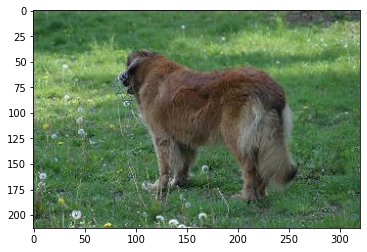

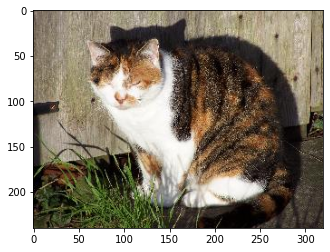

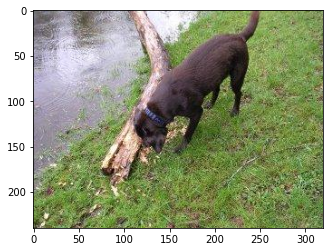

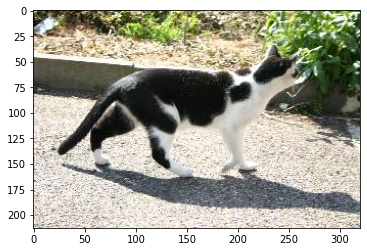

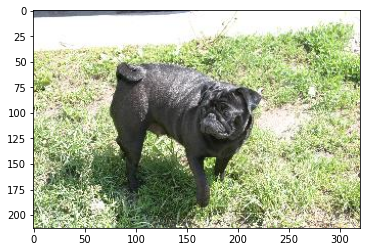

In [17]:
k = 5

for i in range(k):
    plt.imshow(imgs[sorted_index[i]][:,:,::-1])
    plt.show()